# Project P3: Cooperation and Competition &mdash; Synopsis

This notebook collects the results of the various models. The models prior to model 10 were used to find a set of hyperparameters that would train while models 10 to 19 are the systematic product of 128 neurons in hidden layer 1 and 64 in hidden layer 2 imes the discount factor $\gamma$ in the range of [0.90, 0.99].

In [1]:
from pathlib import Path
import json
import re
import shutil

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from itertools import product
from operator import add, sub

## Helper Functions

The following functions are used to sort the existing model paths in the `results` directory. The model paths are of the form `model x` where `x` is an integer.

In [2]:
def atoi(text):
    # convert text to integer if possible
    return int(text) if text.isdigit() else text

def natural_keys(path):
    # extracts an integer from a path to sort paths with a number
    return [atoi(c) for c in re.split('(\d+)', path.name)]

The following function is used to generate the models from several parameters using the itertools product function to generate all possible permutations.

In [3]:
def product_dict(**kwargs):
    keys = kwargs.keys()
    vals = kwargs.values()

    for instance in product(*vals):
        yield dict(zip(keys, instance))

In [4]:
model_grid = {'fc1_units': [64, 128, 256], 'fc2_units': [32, 64, 128, 256]}

models = list()

for i, model in enumerate(list(product_dict(**model_grid))):
    models.append(model)
    
print(f'{len(models)} architectures generated')

models

12 architectures generated


[{'fc1_units': 64, 'fc2_units': 32},
 {'fc1_units': 64, 'fc2_units': 64},
 {'fc1_units': 64, 'fc2_units': 128},
 {'fc1_units': 64, 'fc2_units': 256},
 {'fc1_units': 128, 'fc2_units': 32},
 {'fc1_units': 128, 'fc2_units': 64},
 {'fc1_units': 128, 'fc2_units': 128},
 {'fc1_units': 128, 'fc2_units': 256},
 {'fc1_units': 256, 'fc2_units': 32},
 {'fc1_units': 256, 'fc2_units': 64},
 {'fc1_units': 256, 'fc2_units': 128},
 {'fc1_units': 256, 'fc2_units': 256}]

## Collect all Model Information

In [5]:
# get a sorted list of all model paths
model_dirs = sorted(list(Path('results').glob('model *')), key=natural_keys)

In [6]:
# show first 10 entries
model_dirs[:10]

[PosixPath('results/model 2'),
 PosixPath('results/model 8'),
 PosixPath('results/model 9'),
 PosixPath('results/model 10'),
 PosixPath('results/model 11'),
 PosixPath('results/model 12'),
 PosixPath('results/model 13'),
 PosixPath('results/model 14'),
 PosixPath('results/model 15'),
 PosixPath('results/model 16')]

In [52]:
data = list()

for model_dir in model_dirs:
    try:
        with open(f'{model_dir}/config.json', 'r') as f:
            data.append(json.load(f))
    except FileNotFoundError:
        print(f'{model_dir} is empty')

In [53]:
# only use the model params model_id, fc1_units, fc2_units, gamma and the result target_episode
columns = ['model_id', 'fc1_units', 'fc2_units', 'gamma', 'target_episode']
df = pd.DataFrame(data, columns=columns)

# combine the params fc1_units and fc2_units to create a category label
df['cat'] = df['fc1_units'].map(str) + 'x' + df['fc2_units'].map(str)

# drop the params fc1_units and fc2_units because we created a category label using them
df.drop(['fc1_units', 'fc2_units'], axis='columns', inplace=True)

In [54]:
df

,model_id,gamma,target_episode,cat
0,2,0.99,1793.0,256x128
1,8,0.99,NaN,256x256
2,9,0.99,NaN,128x128
3,10,0.99,1151.0,128x64
4,11,0.98,810.0,128x64
5,12,0.97,1241.0,128x64
6,13,0.96,759.0,128x64
7,14,0.95,3836.0,128x64
8,15,0.94,1952.0,128x64
9,16,0.93,1468.0,128x64


In [55]:
df_dup = df[df[['cat', 'gamma']].duplicated() == True]

df_dup

,model_id,gamma,target_episode,cat


In [58]:
df.loc[df['cat'].isin(['128x64'])].sort_values(by=['gamma'], ascending=False)

,model_id,gamma,target_episode,cat
3,10,0.99,1151.0,128x64
4,11,0.98,810.0,128x64
5,12,0.97,1241.0,128x64
6,13,0.96,759.0,128x64
7,14,0.95,3836.0,128x64
8,15,0.94,1952.0,128x64
9,16,0.93,1468.0,128x64
10,17,0.92,NaN,128x64
11,18,0.91,NaN,128x64
12,19,0.90,NaN,128x64


In [11]:
n_dup = len(df_dup.index)

if n_dup != 0:
    print(f'There are duplicate models in the /results directory')
    reply = input('Enter model_ids to delete (csv): ')

    try:
        model_ids = [m.strip() for m in reply.split(',') if m]
        
        if len(model_ids) and input(f"Deleting models {', '.join(model_ids)}. Ok? [Y/N]") in ['Y', 'y']:
        
            for model_id in model_ids:
                str_ = f'results/model {model_id}/'
                print(f'Deleting folder {str_}...')
                shutil.rmtree(str_)
                                    
    except ValueError:
        print(f'"{reply}" is invalid. Please enter comma separated model_ids. Run cell again')


In [12]:
# create a pivot table with the category label against the gamma values showing the target_episode value
pivot = df.pivot(index='cat', columns='gamma', values='target_episode')

pivot

gamma,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
cat,,,,,,,,,,
128x128,NaN,NaN,NaN,NaN,NaN,NaN,1330.0,913.0,NaN,NaN
128x256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,772.0,NaN,NaN
128x64,NaN,NaN,NaN,1468.0,1952.0,3836.0,759.0,1241.0,810.0,1151.0
256x128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1793.0
256x256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
256x32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
256x512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
256x64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64x128,NaN,NaN,NaN,NaN,NaN,NaN,2874.0,NaN,NaN,NaN


## Pivot Table of Target Episode Scores

In [13]:
data = list()

# the first 6 models were used to experiment. model 10 is the first one in the systematic trials
first_dir = 7

# read all config params for all systematic models into a list
for model_dir in model_dirs[first_dir:]:
    try:
        with open(f'{model_dir}/config.json', 'r') as f:
            data.append(json.load(f))
    except FileNotFoundError:
        pass

In [14]:
# only use the model params fc1_units, fc2_units, gamma and the result target_episode to create a DataFrame
columns = ['fc1_units', 'fc2_units', 'gamma', 'target_episode']
df = pd.DataFrame(data, columns=columns)

# combine the params fc1_units and fc2_units to create a category label
df['cat'] = df['fc1_units'].map(str) + 'x' + df['fc2_units'].map(str)

# drop the params fc1_units and fc2_units because we created a category label using them
df.drop(['fc1_units', 'fc2_units'], axis='columns', inplace=True)

In [15]:
# create a pivot table with the category label against the gamma values showing the target_episode value
pivot = df.pivot(index='cat', columns='gamma', values='target_episode')

pivot

gamma,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97
cat,,,,,,,,
128x128,NaN,NaN,NaN,NaN,NaN,NaN,1330.0,913.0
128x256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,772.0
128x64,NaN,NaN,NaN,1468.0,1952.0,3836.0,NaN,NaN
256x128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
256x256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
256x32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
256x512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
256x64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64x128,NaN,NaN,NaN,NaN,NaN,NaN,2874.0,NaN


## Moving Averages Plot per Architecture

In [16]:
model_grid = {'fc1_units': [128], 'fc2_units': [64]}

In [17]:
models = list()

for i, model in enumerate(list(product_dict(**model_grid))):
    models.append(model)

print(f'{len(models)} architectures generated')

models

1 architectures generated


[{'fc1_units': 128, 'fc2_units': 64}]

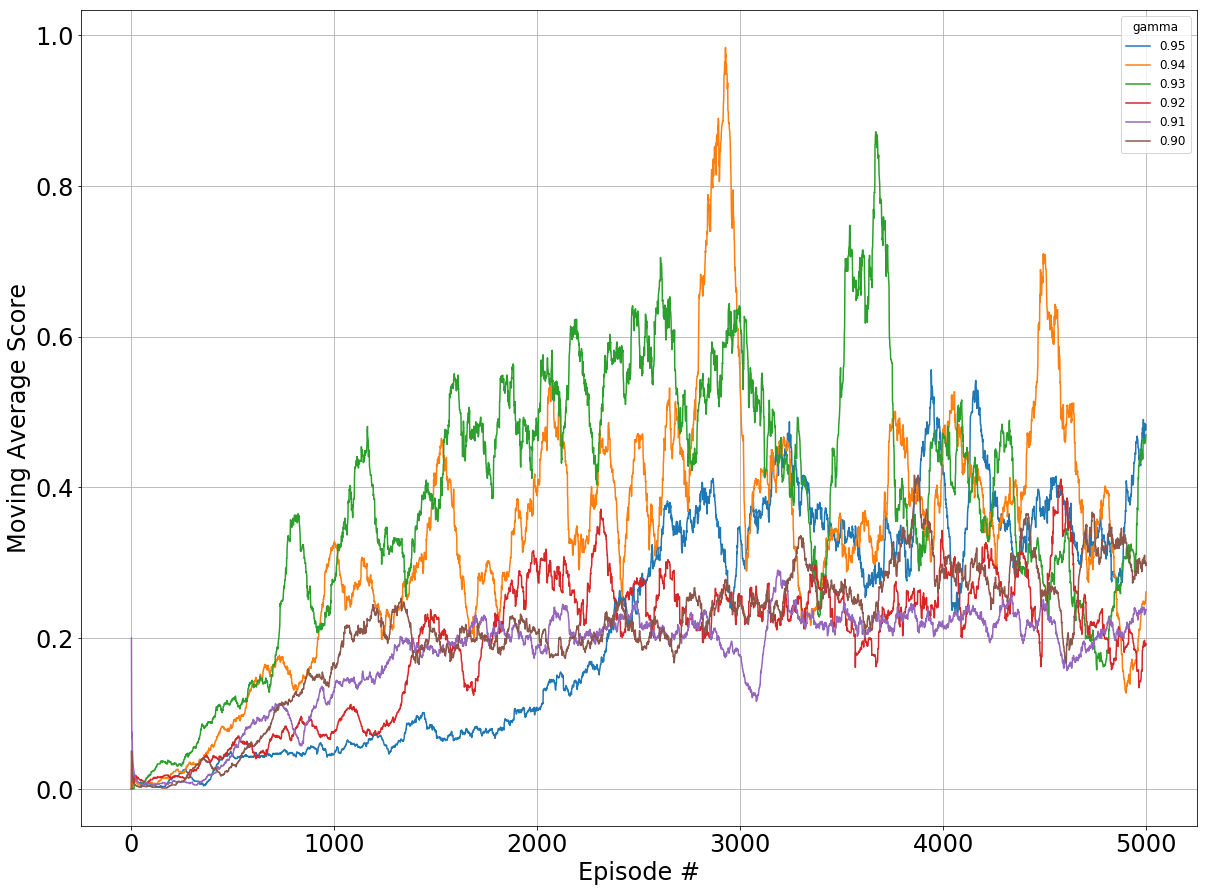

In [35]:
for spec in models:
    fig = plt.figure(figsize=(20, 15))

    for model_dir in model_dirs[first_dir:]:
        try:
            with open(f'{model_dir}/config.json', 'r') as f:
                data = json.load(f)
        except FileNotFoundError:
            pass
        
        if (data['fc1_units'] == spec['fc1_units']) and (data['fc2_units'] == spec['fc2_units']):
            df = pd.read_csv(model_dir / 'scores.csv')

            x = np.arange(len(df['episode']))
            ma_scores = df['ma']
            plt.plot(ma_scores, label=f"{data['gamma']:.2f}")

    plt.xlabel('Episode #')
    plt.ylabel('Moving Average Score')

    plt.grid(True)

    font = {'size': 12}
    plt.rc('font', **font)                                 

    plt.legend(title='gamma')   
    plt.savefig(f"results/{spec['fc1_units']}x{spec['fc2_units']}.png")

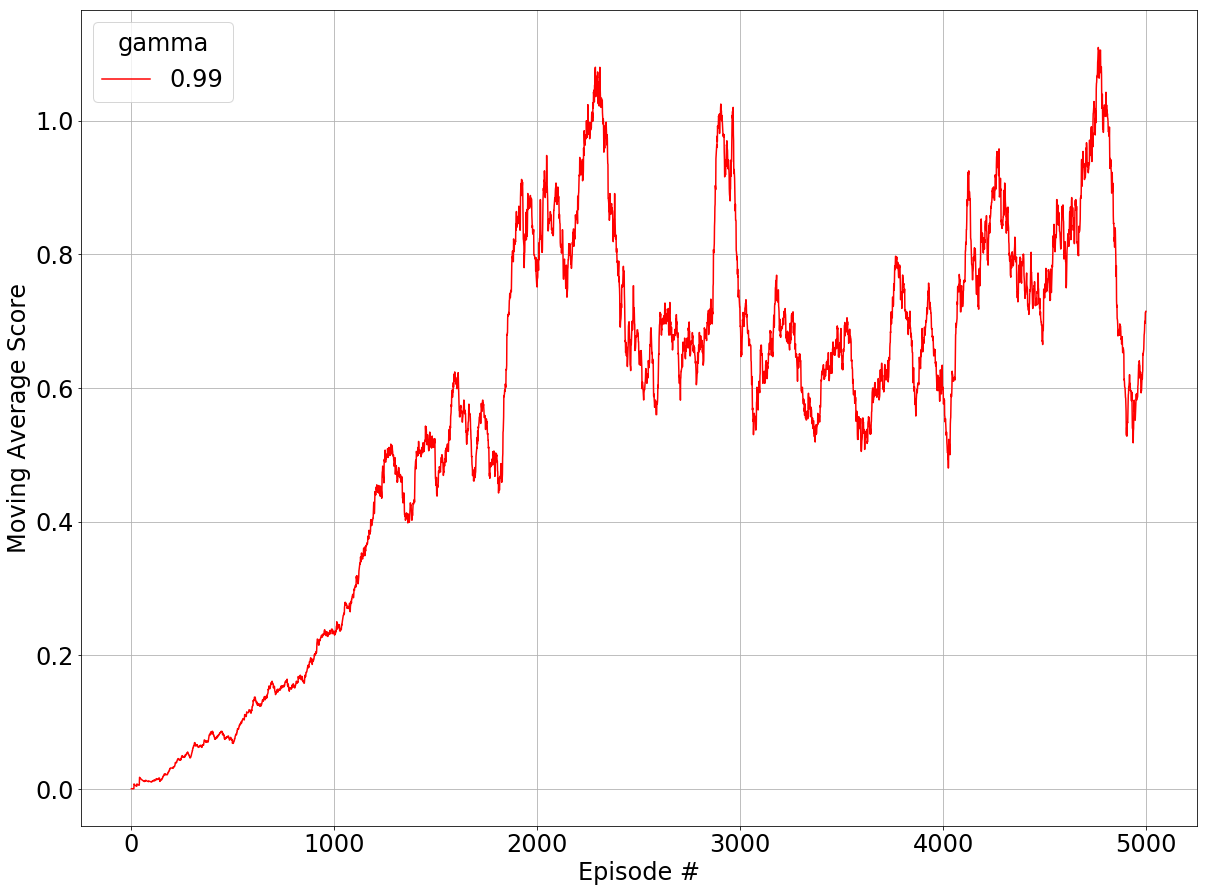

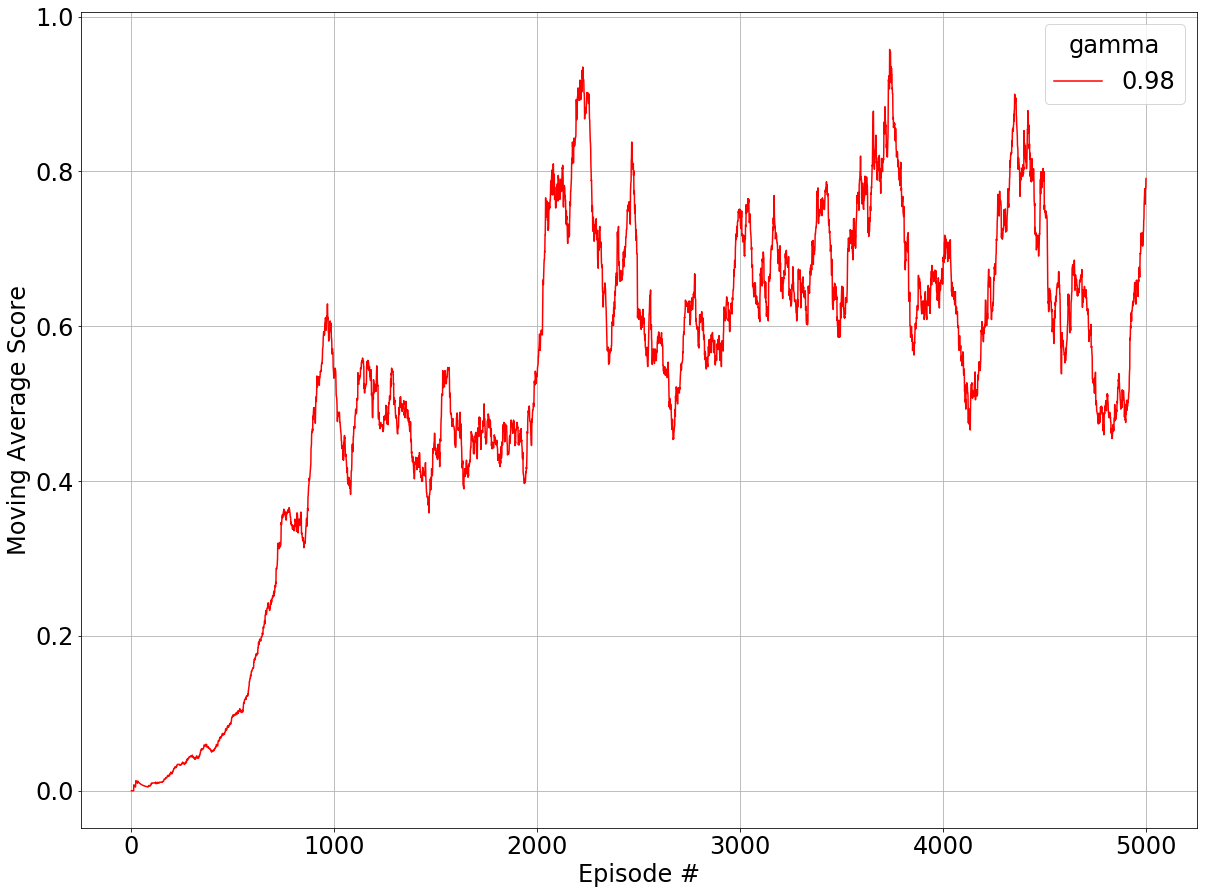

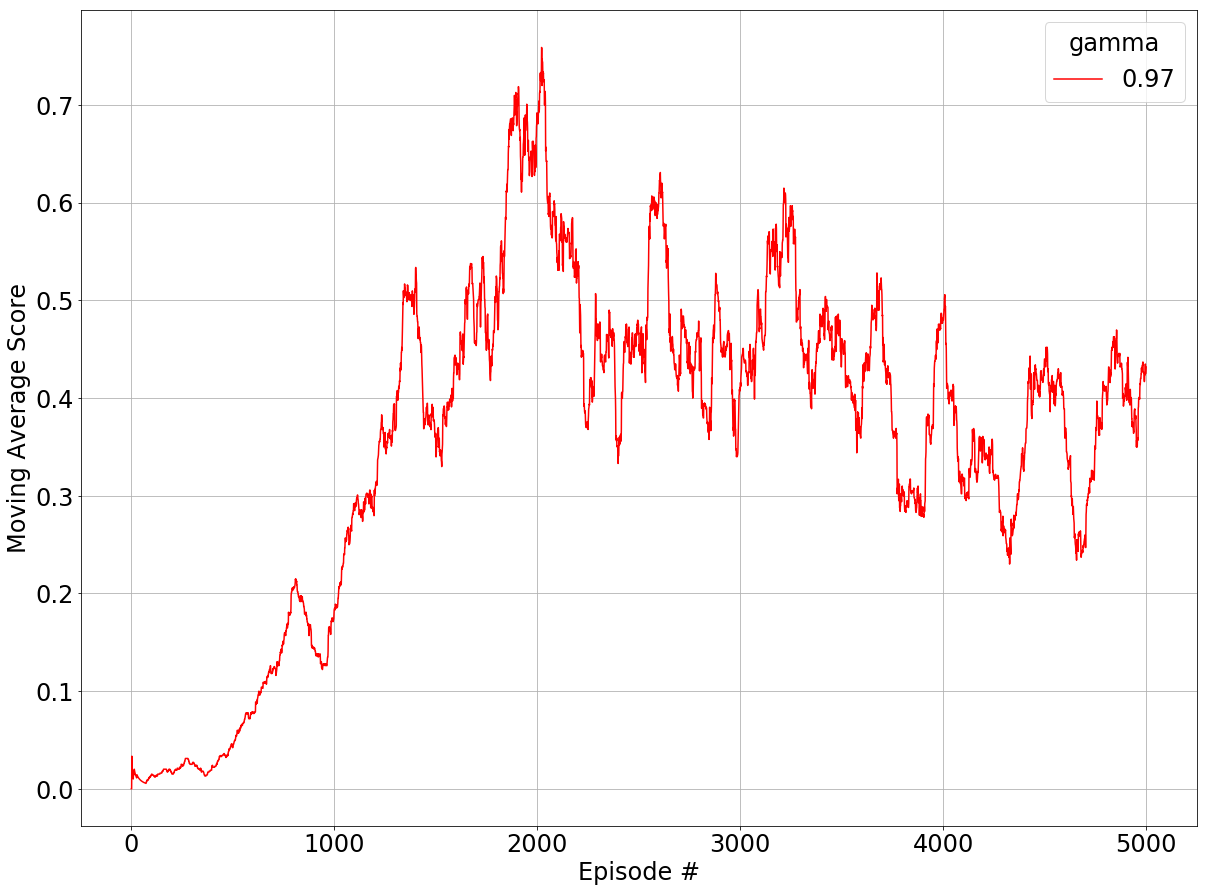

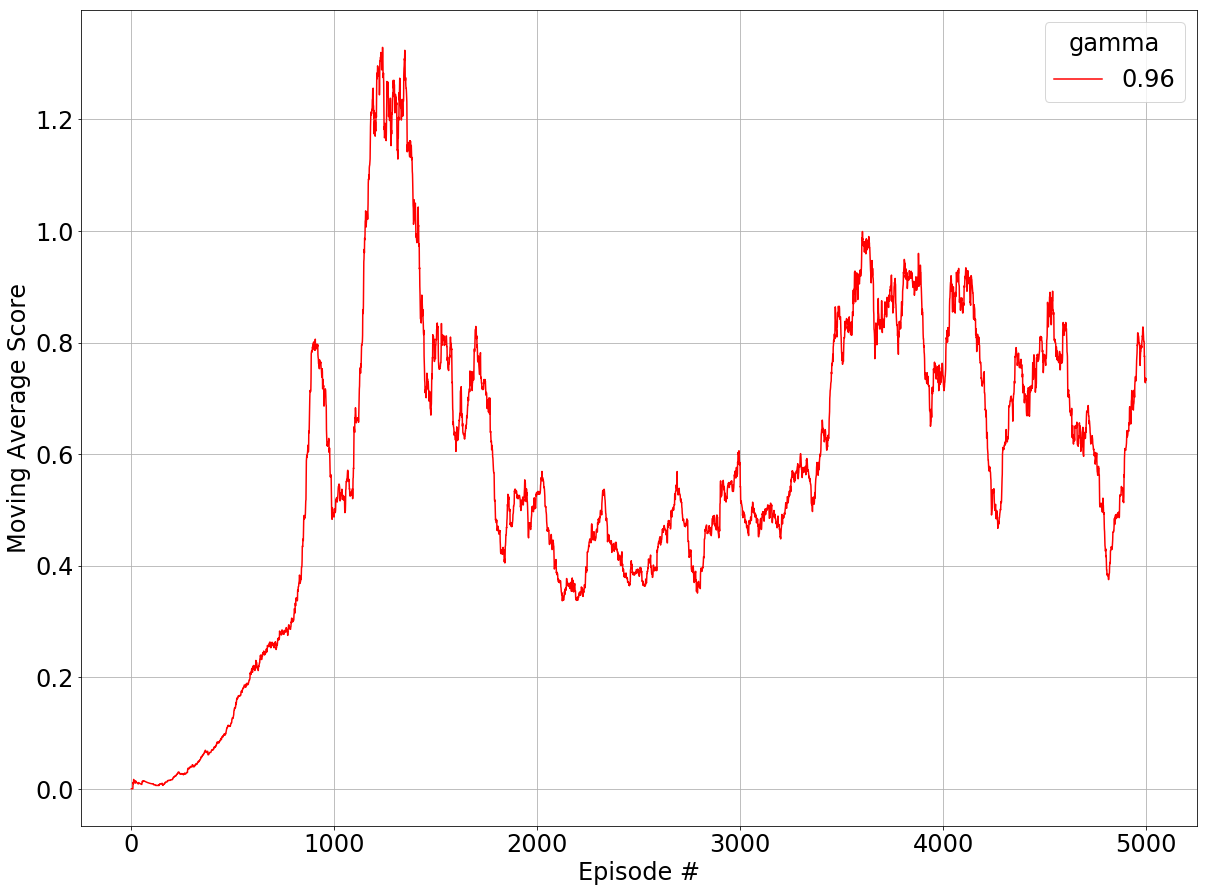

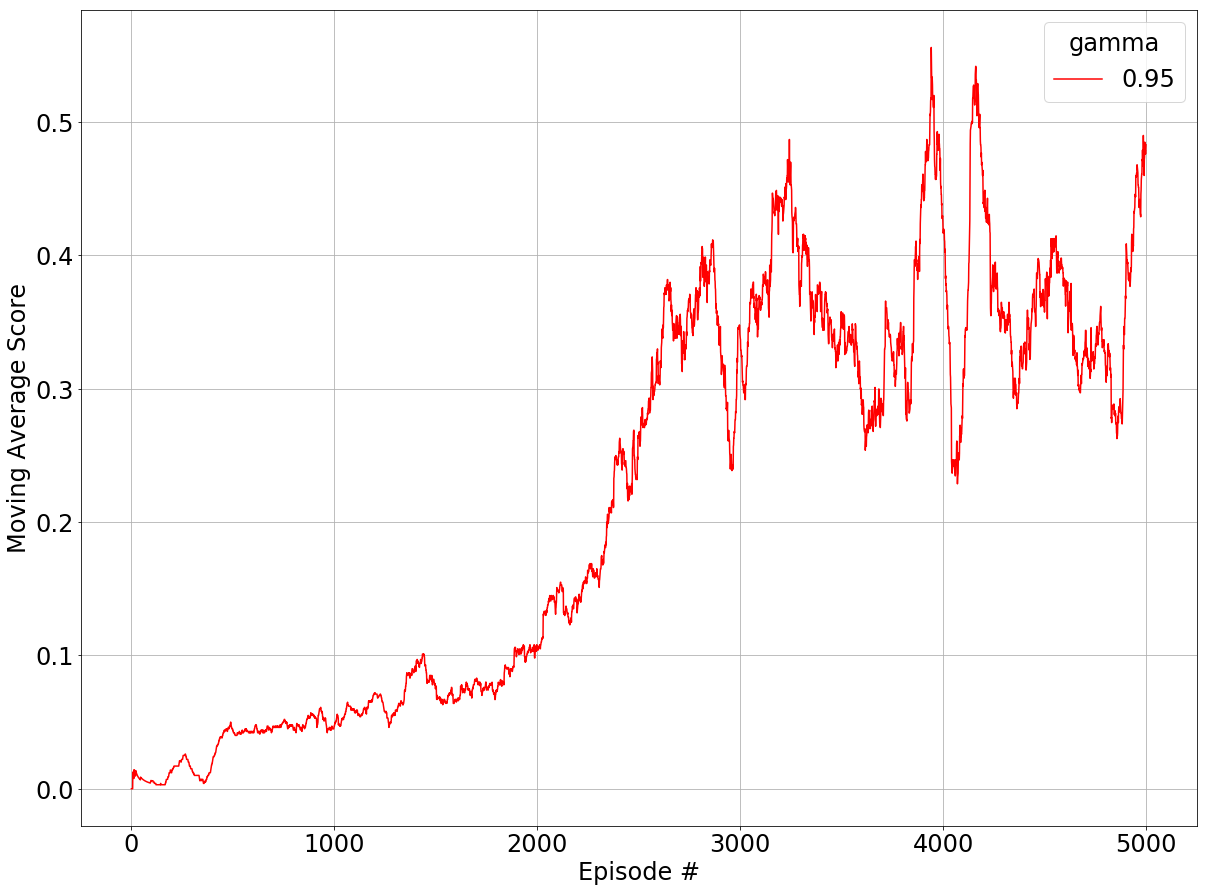

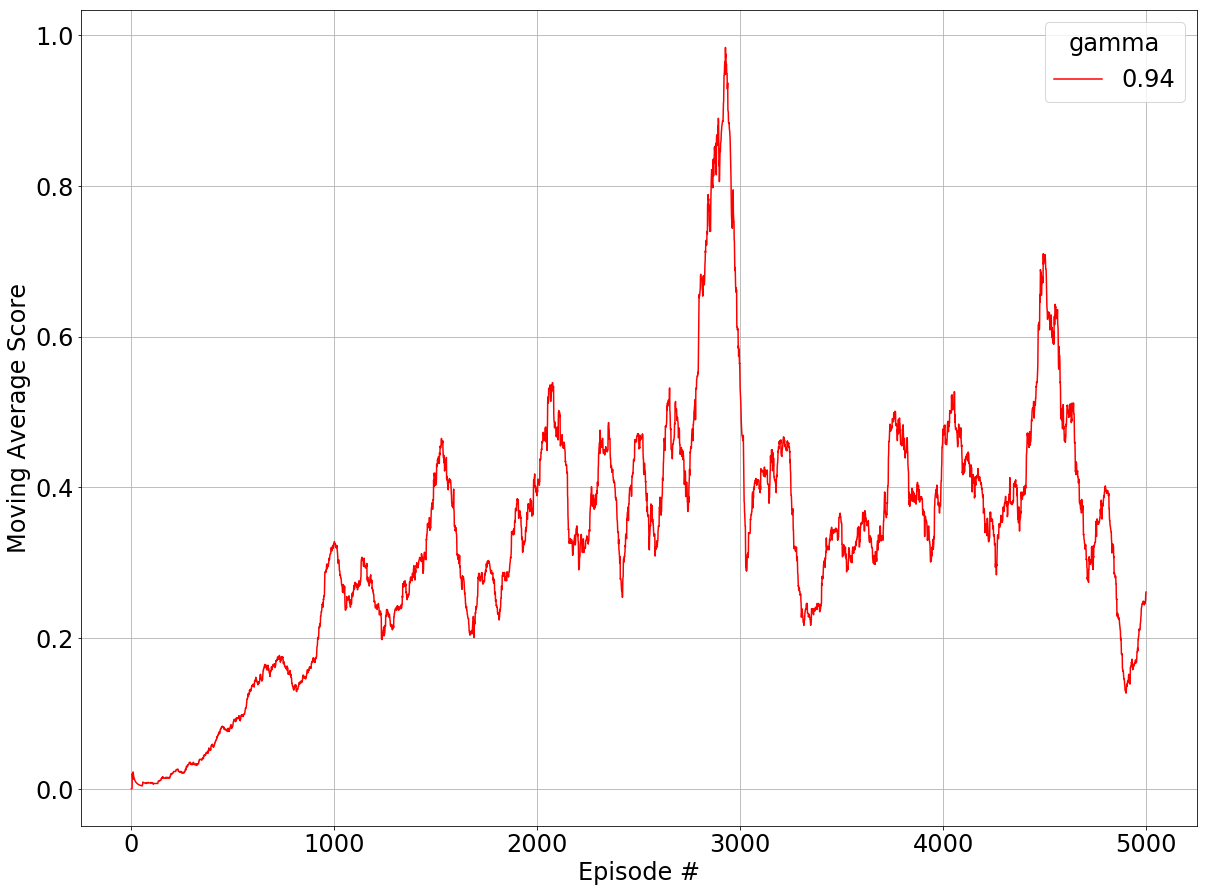

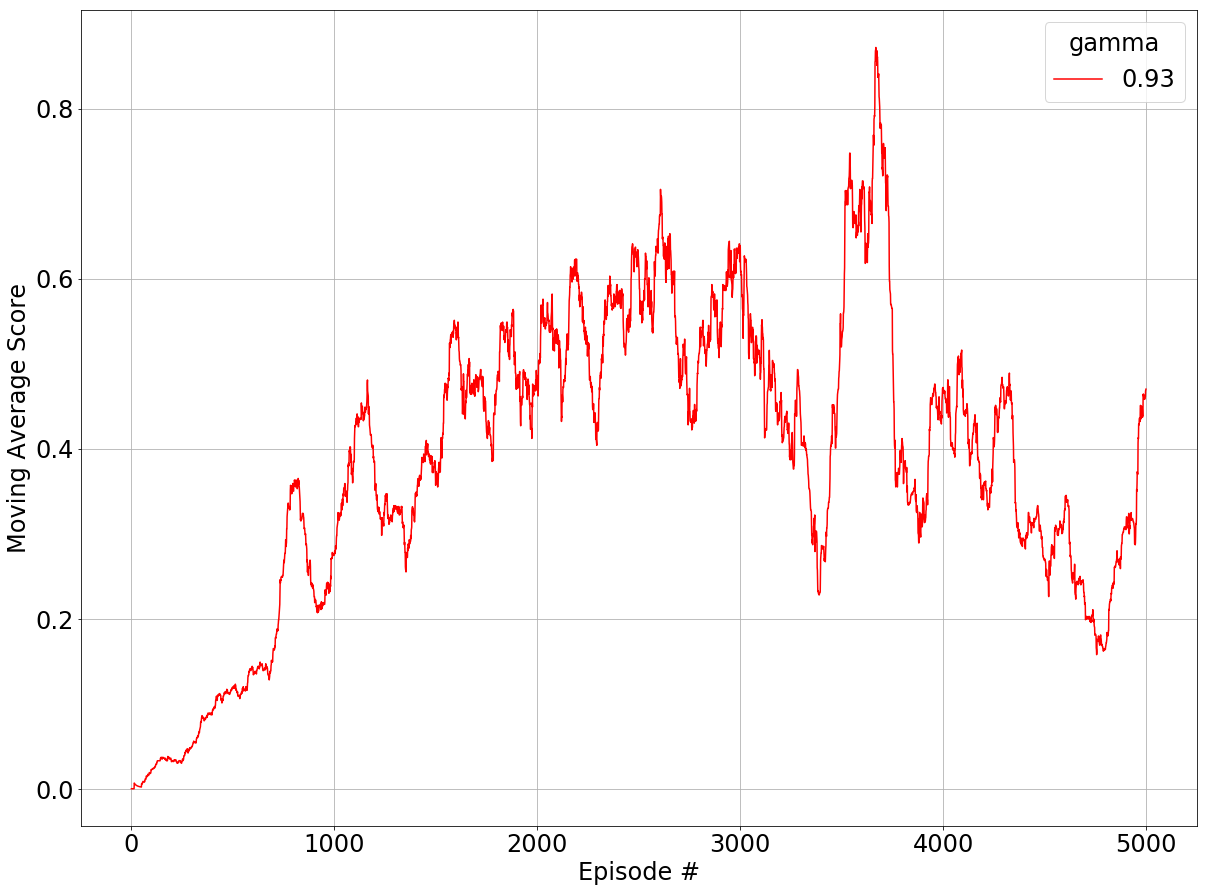

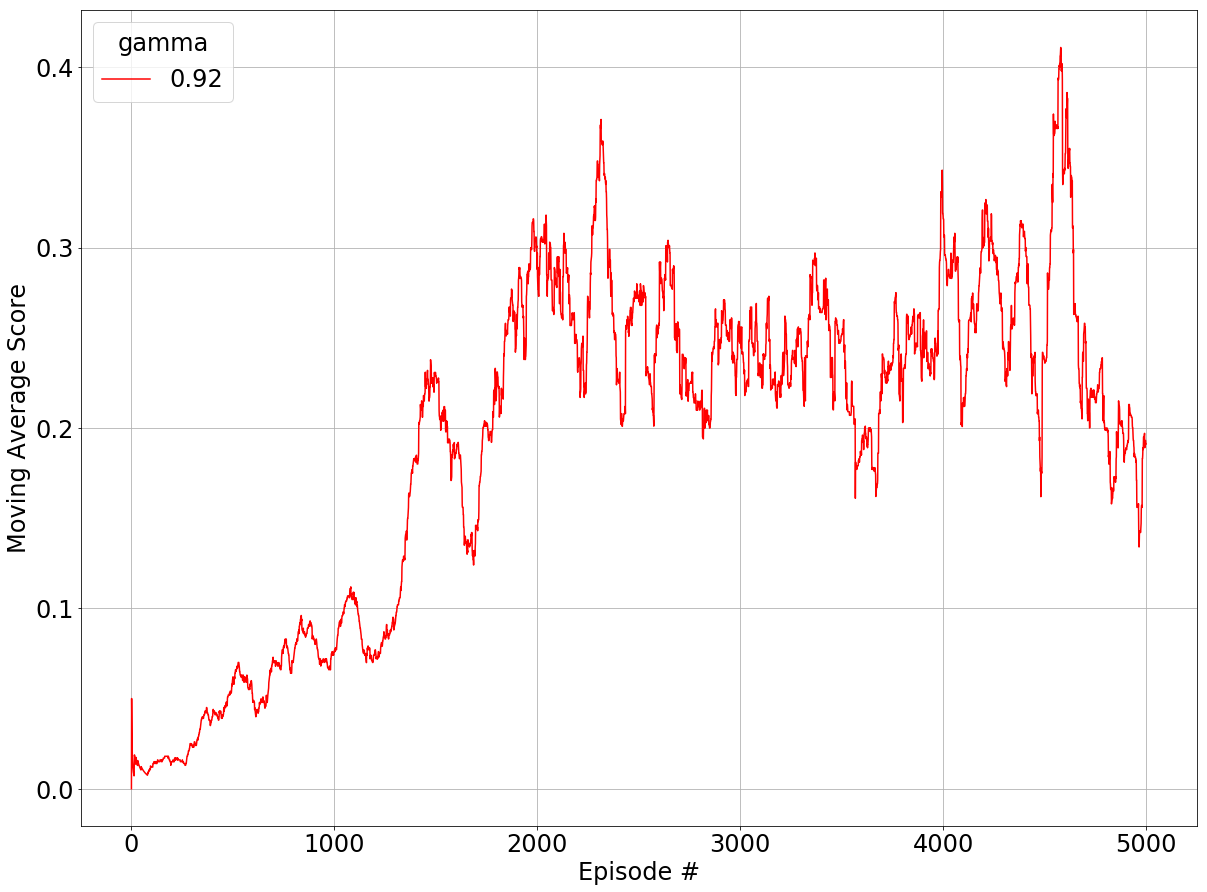

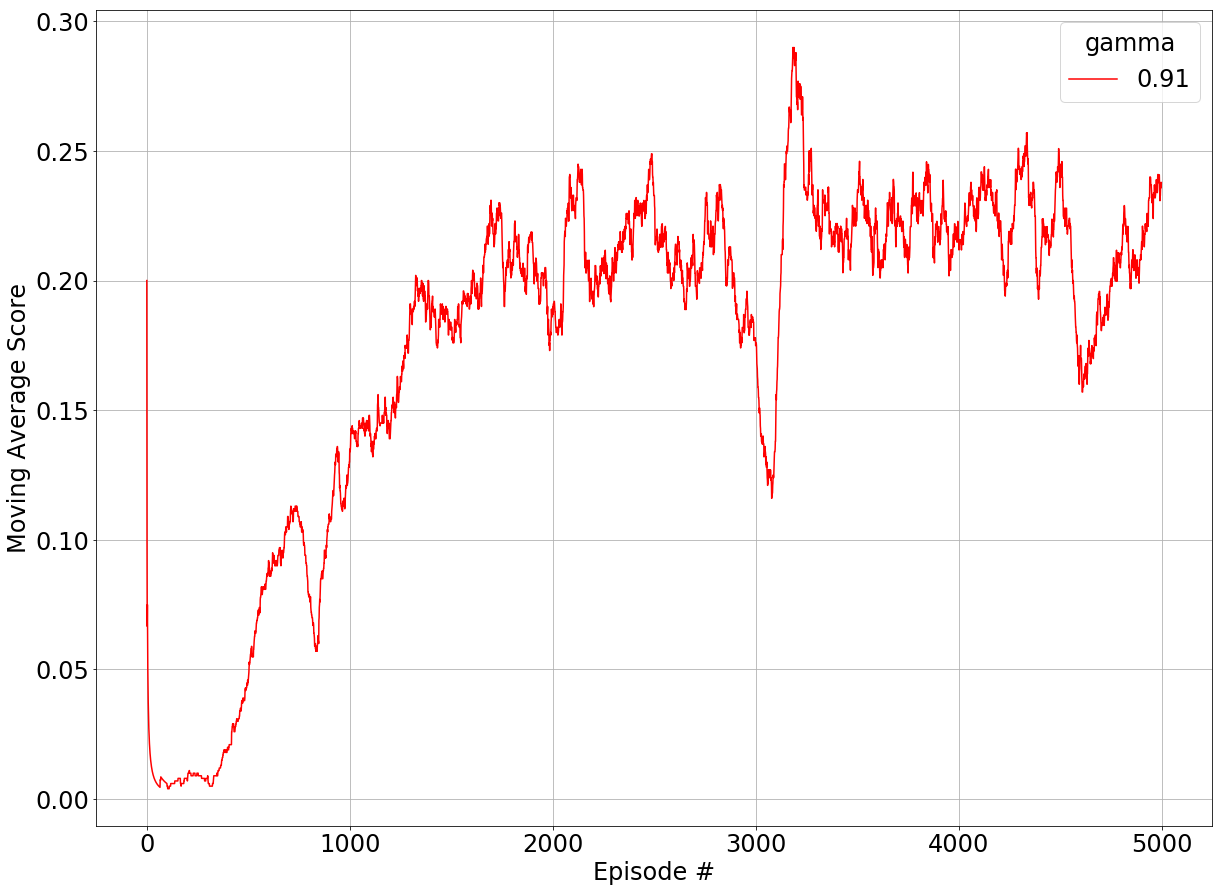

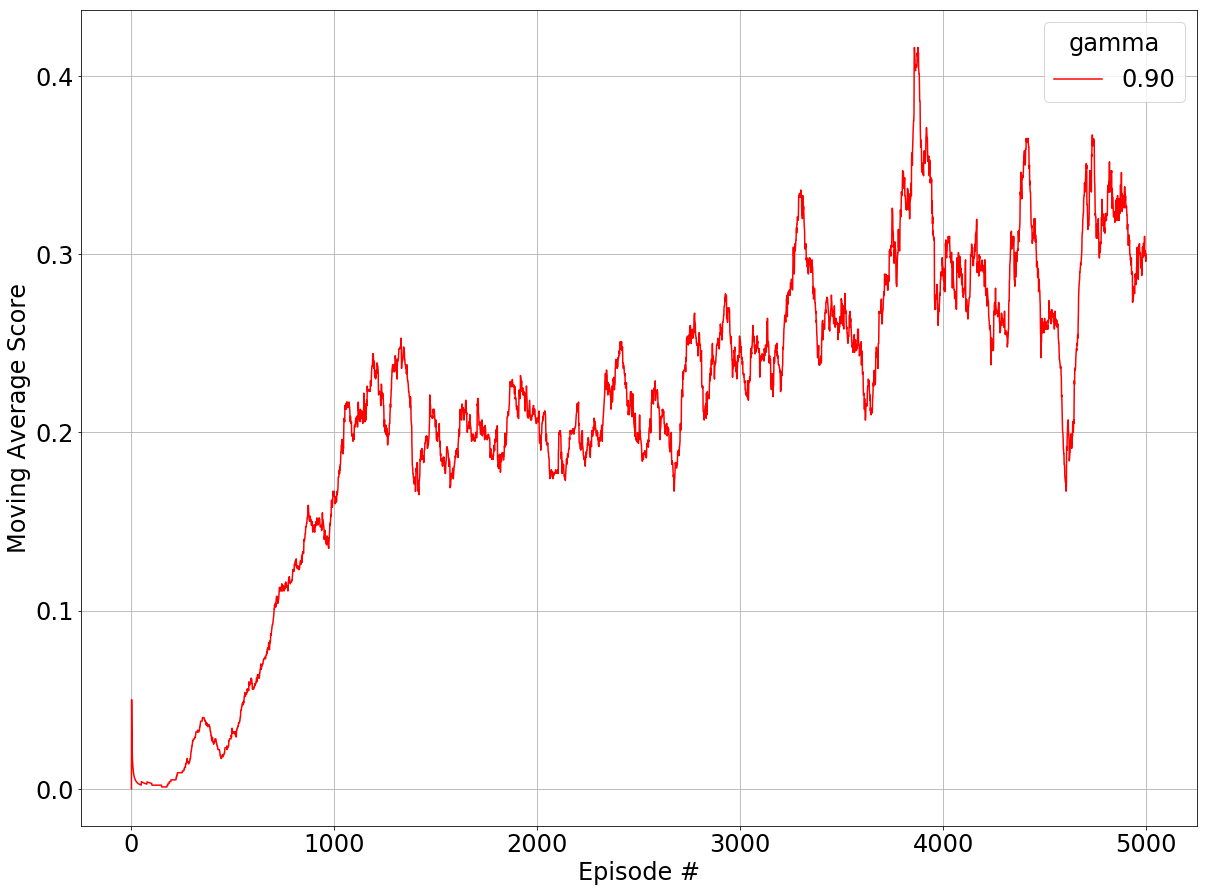

In [49]:
for spec in models:

    for model_dir in model_dirs:
        try:
            with open(f'{model_dir}/config.json', 'r') as f:
                data = json.load(f)
        except FileNotFoundError:
            pass
        
        if (data['fc1_units'] == spec['fc1_units']) and (data['fc2_units'] == spec['fc2_units']):
            df = pd.read_csv(model_dir / 'scores.csv')

            x = np.arange(len(df['episode']))
            ma_scores = df['ma']

            fig = plt.figure(figsize=(20, 15))
            
            plt.plot(ma_scores, label=f"{data['gamma']:.2f}", color='r')

            plt.xlabel('Episode #')
            plt.ylabel('Moving Average Score')

            plt.grid(True)

            font = {'size': 24}
            plt.rc('font', **font)                                 

            plt.legend(title='gamma')   
            plt.savefig(f"results/{spec['fc1_units']}x{spec['fc2_units']}gamma{data['gamma']}.png")

## Plot of an Individual Model

In [40]:
model = 13

In [41]:
model_dir = Path(f'results/model {model}/')

with open(model_dir / 'config.json', 'r') as f:
    data = json.load(f)

df = pd.read_csv(model_dir / 'scores.csv')

x = np.arange(len(df['episode']))

scores = df['score']
ma_scores = df['ma']
std_scores = df['std']

In [42]:
data

{'n_agents': 2,
 'target_episode': 759,
 'target_score': 0.5080000075697899,
 'device': 'cpu',
 'model_id_auto': True,
 'model_id': 13,
 'env_path': 'Tennis.x86_64',
 'brain_name': 'TennisBrain',
 'state_dim': 24,
 'action_dim': 2,
 'n_episodes': 5000,
 'max_t': 2000,
 'buffer_size': 1000000,
 'batch_size': 128,
 'gamma': 0.96,
 'tau': 0.06,
 'lr_actor': 0.001,
 'lr_critic': 0.001,
 'critic_weight_decay': 0,
 'fc1_units': 128,
 'fc2_units': 64,
 'seed': 48,
 'n_print': 100,
 'target': 0.5,
 'window': 100,
 'n_learn_steps': 10,
 'n_learn_updates': 5,
 'all_episodes': True}

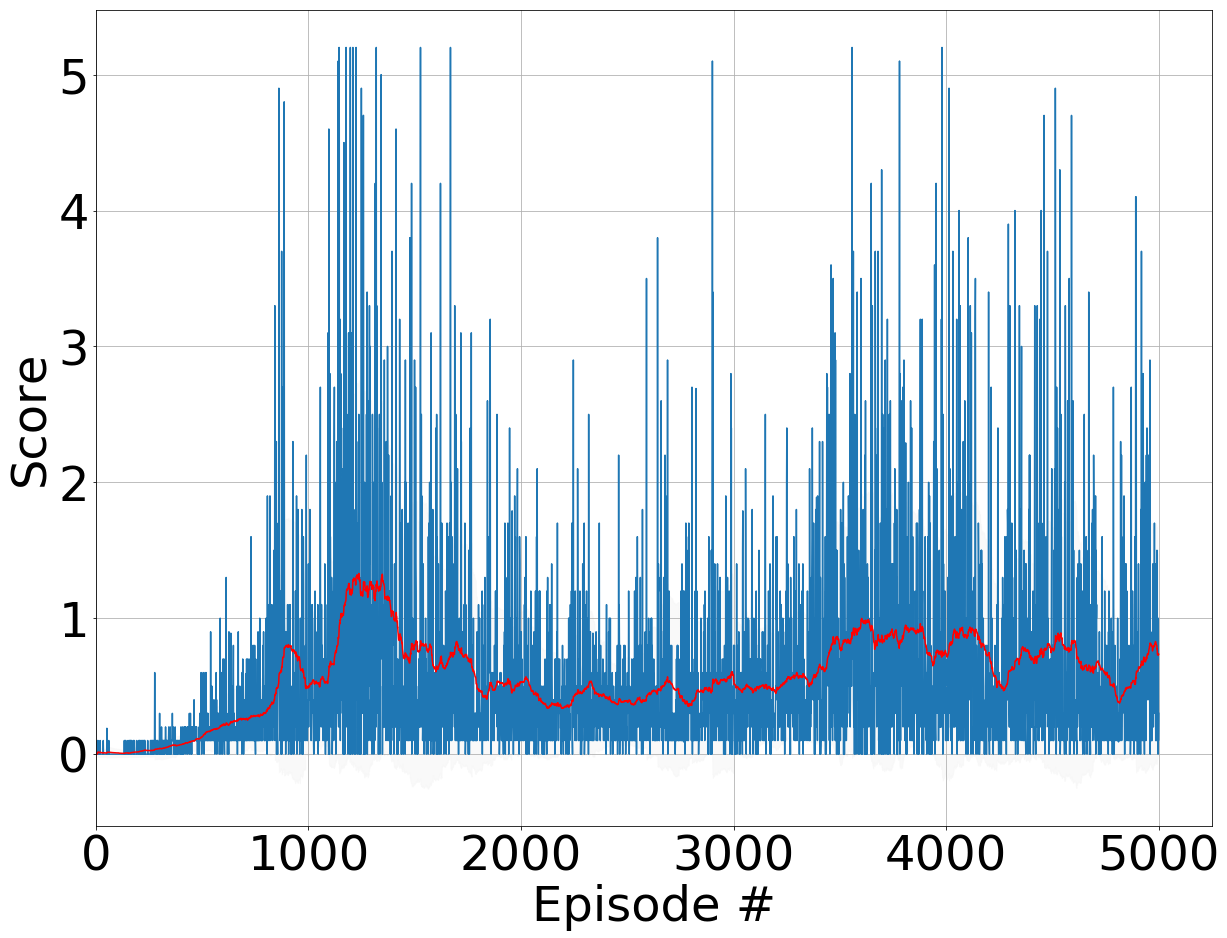

In [47]:
fig = plt.figure(figsize=(20, 15))

plt.plot(x, scores)
plt.plot(x, ma_scores, color='r')
plt.ylabel('Score')
bottom, top = plt.ylim()
# plt.ylim(bottom, 40)

plt.xlabel('Episode #')
left, right = plt.xlim()
plt.xlim(0, right)

plt.grid(True)

font = {'size': 48}
plt.rc('font', **font)

plt.fill_between(x, list(map(sub, ma_scores, std_scores)), list(map(add, ma_scores, std_scores)), 
                 color='whitesmoke', alpha=.5)

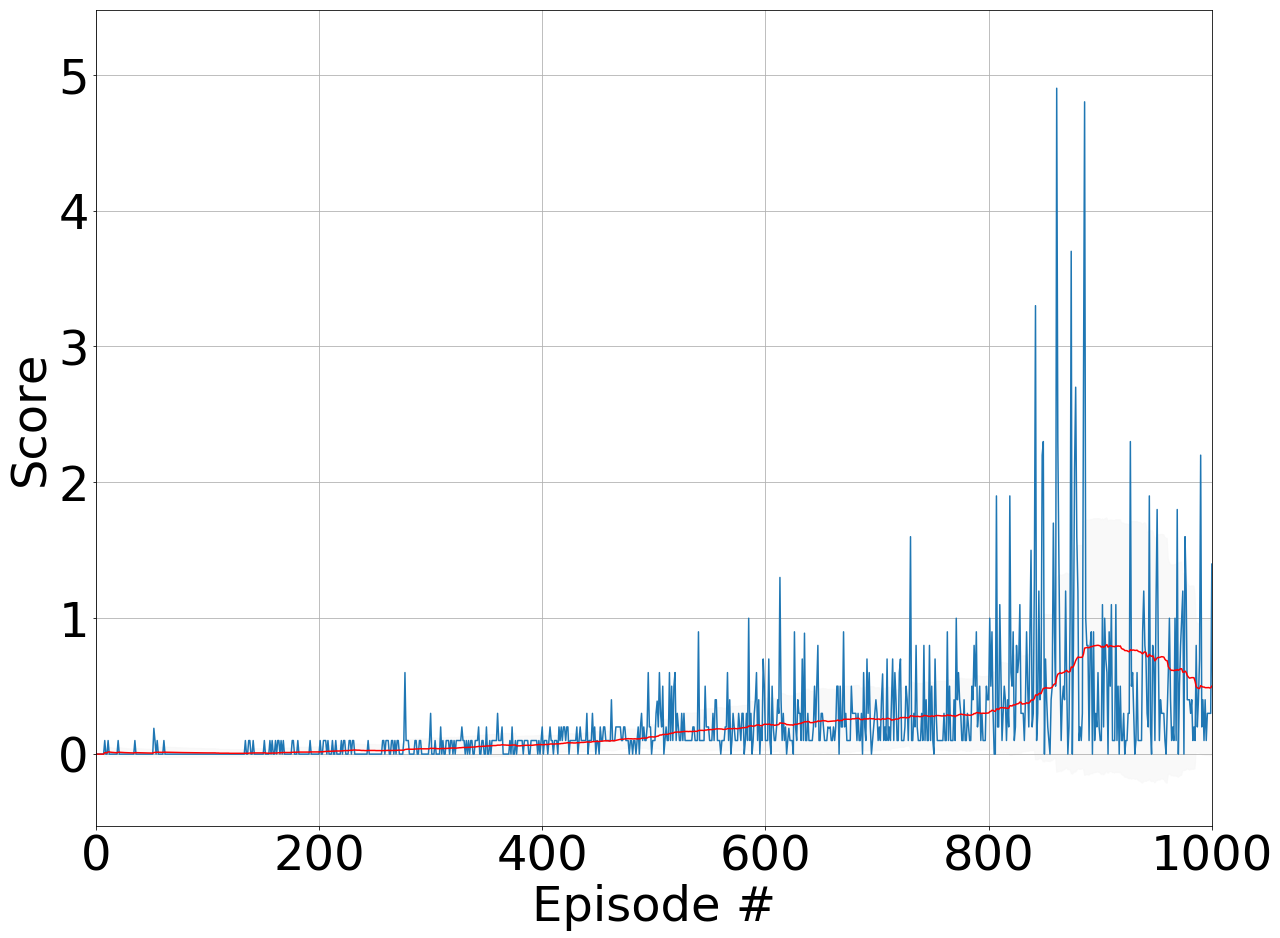

In [28]:
fig = plt.figure(figsize=(20, 15))

plt.plot(x, scores)
plt.plot(x, ma_scores, color='r')
plt.ylabel('Score')
bottom, top = plt.ylim()
# plt.ylim(bottom, 40)

plt.xlabel('Episode #')
left, right = plt.xlim()
plt.xlim(0, 1000)

plt.grid(True)

font = {'size': 48}
plt.rc('font', **font)

plt.fill_between(x, list(map(sub, ma_scores, std_scores)), list(map(add, ma_scores, std_scores)), 
                 color='whitesmoke', alpha=.5)

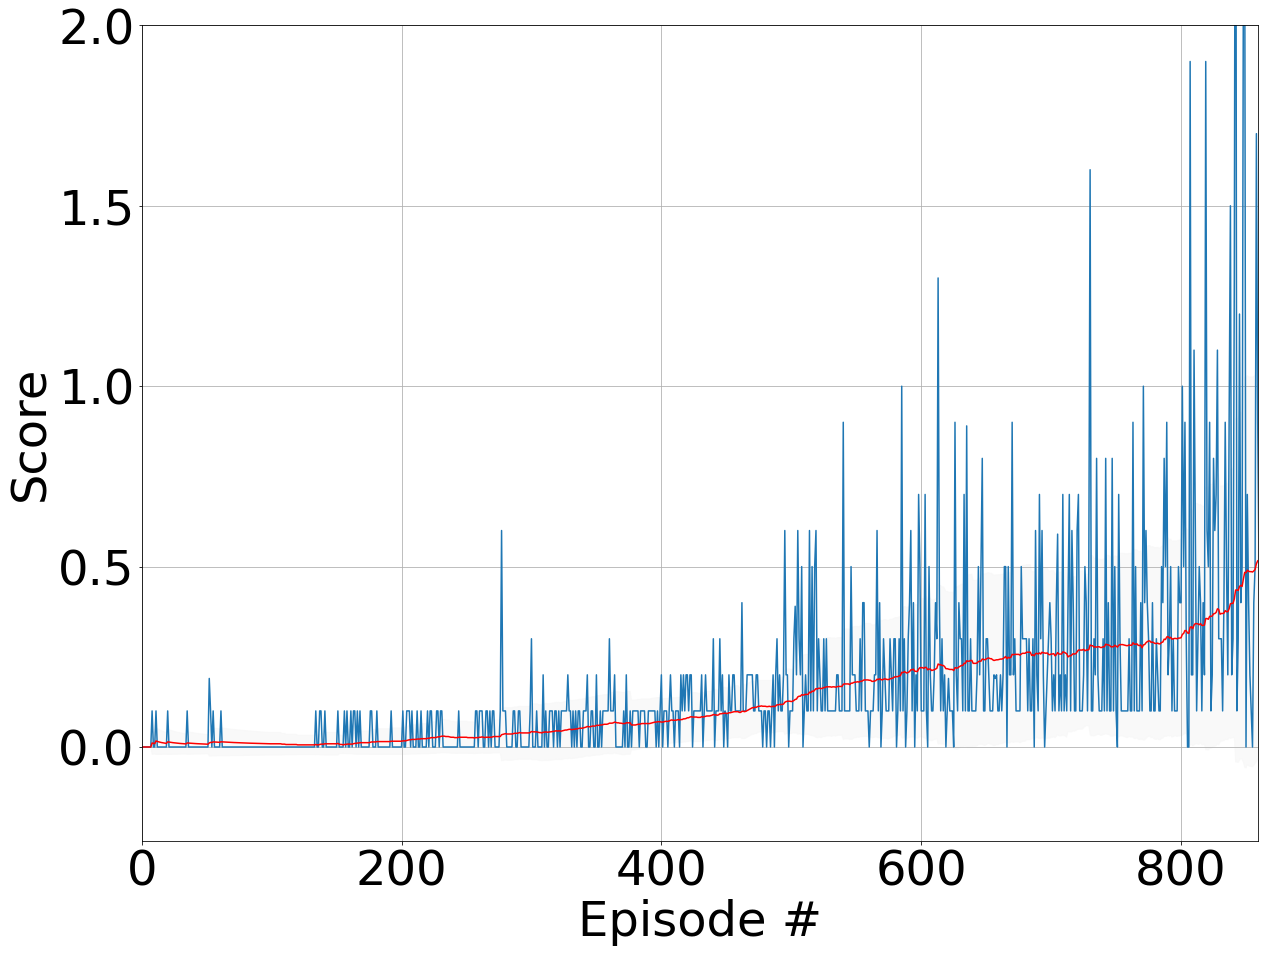

In [29]:
fig = plt.figure(figsize=(20, 15))

plt.plot(x, scores)
plt.plot(x, ma_scores, color='r')
plt.ylabel('Score')
bottom, top = plt.ylim()
plt.ylim(bottom, 2)

plt.xlabel('Episode #')
left, right = plt.xlim()
plt.xlim(0, data['target_episode'] + 100)

plt.grid(True)

font = {'size': 48}
plt.rc('font', **font)

plt.fill_between(x, list(map(sub, ma_scores, std_scores)), list(map(add, ma_scores, std_scores)), 
                 color='whitesmoke', alpha=.5)